# Proyecto 7

Área: Medio Ambiente

Descripción: Deberán **modelar** el consumo de agua en una ciudad durante varios meses o años, utilizando diferentes variables. El objetivo es **identificar** patrones de uso, **predecir** la demanda futura y **evaluar** posibles escenarios de escasez mediante **simulaciones**.


## Análisis del dataset

Para el desarrollo del proyecto usaremos las siguientes bibliotecas :

In [2]:
import numpy as np 
import pandas as pd 
from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors 
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set_style('whitegrid')

Analizamos las columnas del data set, de esto posteriormente nos interezará conocer cuantos valores NaN (Not a Number) tenemos y en que columnas.

In [3]:
aguah = pd.read_csv("./AguaH.csv")
aguah.head()

,USO2013,TU,DC,M,UL,f.1_ENE_09,f.1_FEB_09,f.1_MAR_09,f.1_ABR_09,f.1_MAY_09,...,f.1_MAR_15,f.1_ABR_15,f.1_MAY_15,f.1_JUN_15,f.1_JUL_15,f.1_AGO_15,f.1_SEP_15,f.1_OCT_15,f.1_NOV_15,f.1_DIC_15
0,H3,DOMESTICO MEDIO,0.5,MSDELAUNET,197.0,20.0,20.0,20.0,20.0,20.0,...,2.0,1.0,2.0,1.0,7.0,7.0,42.0,27.0,22.0,21.0
1,H3,DOMESTICO MEDIO,0.5,MSDELAUNET,307.0,NaN,30.0,30.0,30.0,30.0,...,11.0,13.0,16.0,14.0,15.0,16.0,13.0,17.0,17.0,11.0
2,H3,DOMESTICO RESIDENCIAL,0.5,MSDELAUNET,179.0,NaN,NaN,NaN,NaN,NaN,...,6.0,9.0,7.0,8.0,8.0,10.0,12.0,9.0,6.0,3.0
3,H3,DOMESTICO MEDIO,0.5,CICASA MMD-15 S,852.0,NaN,NaN,NaN,NaN,NaN,...,17.0,20.0,16.0,16.0,18.0,18.0,17.0,17.0,18.0,9.0
4,H3,DOMESTICO RESIDENCIAL,0.5,NaN,NaN,20.0,20.0,20.0,20.0,20.0,...,27.0,27.0,27.0,28.0,28.0,31.0,27.0,27.0,27.0,24.0


In [4]:
lookup = {'ENE':'01',
          'FEB':'02',
          'MAR':'03',
          'ABR':'04',
          'MAY':'05',
          'JUN':'06',
          'JUL':'07',
          'AGO':'08',
          'SEP':'09',
          'OCT':'10',
          'NOV':'11',
          'DIC':'12'
          }
clist=[]
for col in aguah.columns[5:]:
    col = col[4:].split('_')
    clist.append('20'+col[1]+'-'+lookup[col[0]])

columns = ['TIPO USO','TIPO USUARIO','DIAMETRO_TUBERIA','PROVEEDOR','ENE16']+clist
aguah.columns=columns
aguah.head()

,TIPO USO,TIPO USUARIO,DIAMETRO_TUBERIA,PROVEEDOR,ENE16,2009-01,2009-02,2009-03,2009-04,2009-05,...,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12
0,H3,DOMESTICO MEDIO,0.5,MSDELAUNET,197.0,20.0,20.0,20.0,20.0,20.0,...,2.0,1.0,2.0,1.0,7.0,7.0,42.0,27.0,22.0,21.0
1,H3,DOMESTICO MEDIO,0.5,MSDELAUNET,307.0,NaN,30.0,30.0,30.0,30.0,...,11.0,13.0,16.0,14.0,15.0,16.0,13.0,17.0,17.0,11.0
2,H3,DOMESTICO RESIDENCIAL,0.5,MSDELAUNET,179.0,NaN,NaN,NaN,NaN,NaN,...,6.0,9.0,7.0,8.0,8.0,10.0,12.0,9.0,6.0,3.0
3,H3,DOMESTICO MEDIO,0.5,CICASA MMD-15 S,852.0,NaN,NaN,NaN,NaN,NaN,...,17.0,20.0,16.0,16.0,18.0,18.0,17.0,17.0,18.0,9.0
4,H3,DOMESTICO RESIDENCIAL,0.5,NaN,NaN,20.0,20.0,20.0,20.0,20.0,...,27.0,27.0,27.0,28.0,28.0,31.0,27.0,27.0,27.0,24.0


### Datos nulos (NaN)

Identificamos los valores diferentes de NaN, mismos que nos serviran para imputar los datos NaN posteriormente:

Proporción de valores distintos de NaN : 79.06%


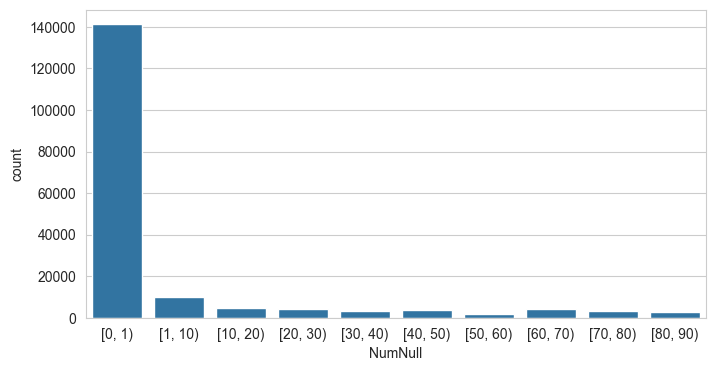

In [5]:
cons = aguah.iloc[0:, 5:]
cons['NumNull'] = cons.isnull().sum(axis=1)
print('Proporción de valores distintos de NaN : {:.2f}%'.format(len(cons[cons.NumNull==0])/len(cons)*100))
bins = [0,1,10,20,30,40,50,60,70,80,90]
cut = pd.cut(cons.NumNull, bins=bins, include_lowest=True, right=False)
fig, axis1 = plt.subplots(1,figsize=(8,4))
sns.countplot(x=cut, data=cut.to_frame(), ax=axis1)
plt.show()

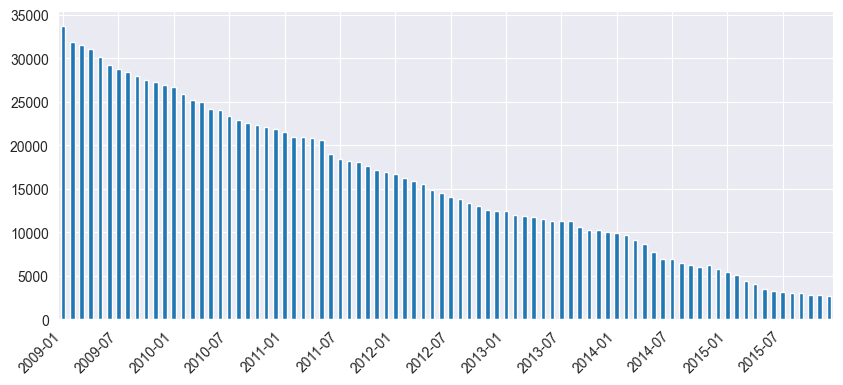

In [6]:
NumNullwithTime = cons.drop('NumNull', axis=1).isnull().sum()

sns.set_style("darkgrid")
plt.figure(figsize=(10,4))
pbar = NumNullwithTime.plot.bar()
plt.xticks(list(range(0,len(NumNullwithTime.index),6)), list(NumNullwithTime.index[0::6]), rotation=45, ha='right')
plt.show()

### Imputación de datos faltantes


* **Intento con SimpleImputer**

In [7]:
from sklearn.impute import SimpleImputer

In [8]:

data = aguah.iloc[0:, 5:]

imputer = SimpleImputer(strategy='mean')

imputed_array = imputer.fit_transform(data)


df_imputed = pd.DataFrame(imputed_array, columns=data.columns)


df_imputed.to_csv('datos_imputados.csv', index=False)
print('Proceso de Imputación terminado')

Proceso de Imputación terminado


* **Inteno con KNN**

In [42]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

In [43]:
data = aguah.iloc[0:, 5:]
print(data)

        2009-01  2009-02  2009-03  2009-04  2009-05  2009-06  2009-07  \
0          20.0     20.0     20.0     20.0     20.0     20.0     20.0   
1           NaN     30.0     30.0     30.0     30.0     30.0     30.0   
2           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
3           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
4          20.0     20.0     20.0     20.0     20.0     20.0     20.0   
...         ...      ...      ...      ...      ...      ...      ...   
178592   2574.0   1685.0   1141.0   1316.0   1521.0   2388.0   2620.0   
178593   2574.0   1685.0   1141.0   1316.0   1521.0   2388.0   2620.0   
178594   2574.0   1685.0   1141.0   1316.0   1521.0   2388.0   2620.0   
178595   2574.0   1685.0   1141.0   1316.0   1521.0   2388.0   2620.0   
178596   2574.0   1685.0   1141.0   1316.0   1521.0   2388.0   2620.0   

        2009-08  2009-09  2009-10  ...  2015-03  2015-04  2015-05  2015-06  \
0          20.0     20.0     20.0  ...      2

In [44]:
#Filatrar filas incompletas
complete_rows = data.dropna()
incomplete_rows = data[data.isnull().any(axis=1)]
print(complete_rows)
print(incomplete_rows)

        2009-01  2009-02  2009-03  2009-04  2009-05  2009-06  2009-07  \
0          20.0     20.0     20.0     20.0     20.0     20.0     20.0   
4          20.0     20.0     20.0     20.0     20.0     20.0     20.0   
5          20.0     20.0     20.0     20.0     20.0     20.0     20.0   
6          20.0     20.0     20.0     20.0     20.0     20.0     20.0   
7          30.0     10.0     30.0     20.0     30.0     30.0     30.0   
...         ...      ...      ...      ...      ...      ...      ...   
178592   2574.0   1685.0   1141.0   1316.0   1521.0   2388.0   2620.0   
178593   2574.0   1685.0   1141.0   1316.0   1521.0   2388.0   2620.0   
178594   2574.0   1685.0   1141.0   1316.0   1521.0   2388.0   2620.0   
178595   2574.0   1685.0   1141.0   1316.0   1521.0   2388.0   2620.0   
178596   2574.0   1685.0   1141.0   1316.0   1521.0   2388.0   2620.0   

        2009-08  2009-09  2009-10  ...  2015-03  2015-04  2015-05  2015-06  \
0          20.0     20.0     20.0  ...      2

In [45]:
scaler = StandardScaler()
complete_scaled = scaler.fit_transform(complete_rows)
incomplete_scaled = scaler.transform(incomplete_rows)

In [46]:
# configurar el imputador
imputer = KNNImputer(n_neighbors=5)

In [ ]:
# Procesar por Chunks
chunk_size = 10000
num_incomplete = len(incomplete_rows)
imputed_blocks = []

for start in range(0, num_incomplete, chunk_size):
    end = min(start + chunk_size, num_incomplete)
    print(f'\n filas en proceso: {start} a {end - 1}...')

    # Extraer bloque
    incomplete_chunk = incomplete_scaled[start:end]

    # Combinar con datos completos (vecinos)
    combined_chunk = np.vstack([complete_scaled, incomplete_chunk])

    # Imputar
    imputed_combined = imputer.fit_transform(combined_chunk)

    # Extraer solo la parte imputada
    imputed_chunk_scaled = imputed_combined[-(end - start):]

    # Desnormalizar
    imputed_chunk_original = scaler.inverse_transform(imputed_chunk_scaled)

    # Convertir a DataFrame
    imputed_chunk_df = pd.DataFrame(imputed_chunk_original, columns=data.columns)
    imputed_blocks.append(imputed_chunk_df)

    print(f'Bloque {start} - {end - 1} imputado.')

In [ ]:
imputed_incomplete_df = pd.concat(imputed_blocks, ignore_index=True)

In [ ]:
final_df = pd.concat([complete_rows, imputed_incomplete_df], ignore_index=True)

print('\n Imputación terminada:')
print(final_df.info())

In [ ]:
final_df.to_csv('datos_imputados_por_bloques.csv', index=False)
print("\n Archivo 'datos_imputados_por_bloques.csv' guardado correctamente.")


In [38]:
# Normalizar
scaler = StandardScaler()
complete_scaled = scaler.fit_transform(complete_rows)
incomplete_scaled = scaler.fit_transform(incomplete_rows)

#Concatenar
combined_scaled = np.vstack([complete_scaled, incomplete_scaled])


In [ ]:
#Imputar
imputer = KNNImputer(n_neighbors=5)
data_imputed = imputer.fit_transform(combined_scaled)

In [ ]:
#Separar los resultados imputados
imputed_incomplete_scaled = imputed_scaled[-len(incomplete_rows):]

In [ ]:

data_imputed = pd.DataFrame(data_imputed, columns = data.columns)
print(data_imputed)

## Análisis de los datos Imputados

Con los datos imputados, graficamos el consumo con respecto al tiempo.

* **Serie de tiempo**

In [9]:
df_datos_imputados = pd.read_csv('./datos_imputados.csv')

In [10]:
df_long = df_datos_imputados.melt(var_name='Fecha', value_name='Consumo')


<Axes: xlabel='Fecha'>

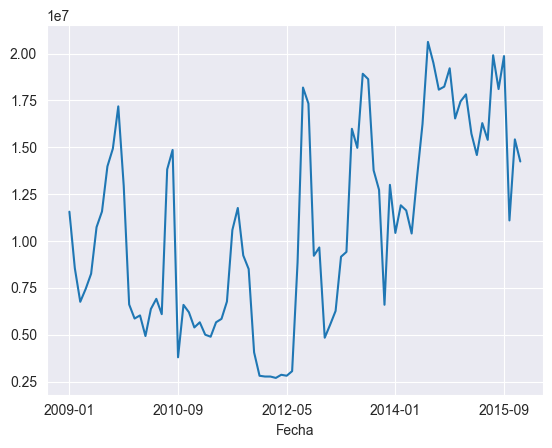

In [11]:
df_long.groupby('Fecha')['Consumo'].sum().plot()


El consumo de agua aumenta con el paso del tiempo del 2009 al 2015 el consumo muestra una tendencia ascendente, aunque también se presentan caidas en periodos intermedios.
Un aspecto importante a considerar es la variabilidad, algunos periodos muestra caídas muy bruscas y repidaente se recuperan, siendo una muy clara muestra que el consumo no es constante si no que fluctua


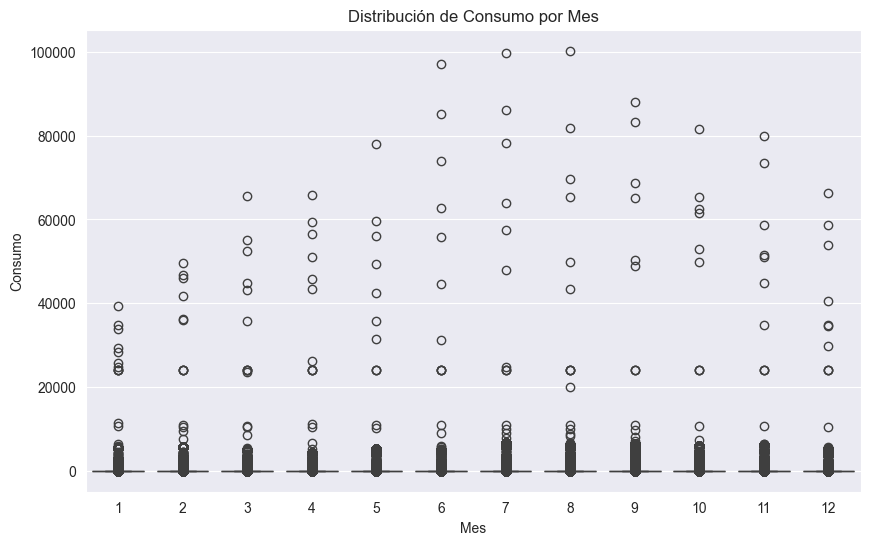

In [13]:
df_long['Fecha'] = pd.to_datetime(df_long['Fecha'])


df_long['Mes'] = df_long['Fecha'].dt.month

plt.figure(figsize=(10,6))
sns.boxplot(x='Mes', y='Consumo', data=df_long)
plt.title('Distribución de Consumo por Mes')
plt.xlabel('Mes')
plt.ylabel('Consumo')
plt.show()